<a href="https://colab.research.google.com/github/uvads6050/DS6050---24F/blob/main/M7_3_Tutorial_Processing_sequences_using_rnns_and_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial 7.3 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code for RNNS_

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

C:\Users\zlism\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


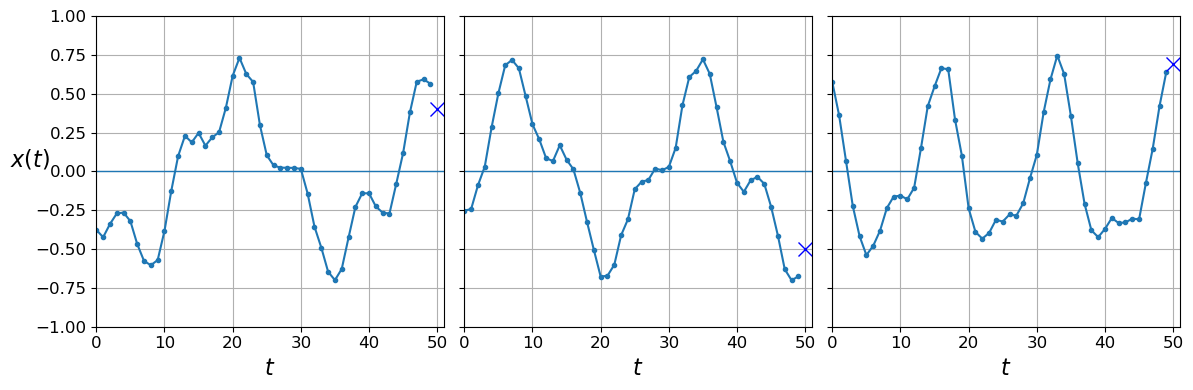

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [8]:
from tensorflow.keras.losses import MeanSquaredError

y_pred = X_valid[:, -1]
mse = MeanSquaredError()
np.mean(mse(y_valid, y_pred))

0.020211365

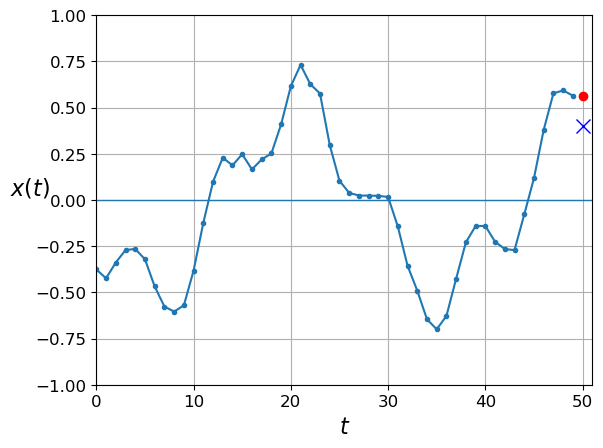

In [9]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1308 - val_loss: 0.0644
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0535 - val_loss: 0.0316
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0277 - val_loss: 0.0194
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0178 - val_loss: 0.0147
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.0116 - val_loss: 0.0107
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0101 - val_loss: 0.0095
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.0090 - val_loss: 0.0084
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0080 - val_loss: 0.0075
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 0.0073 - val_loss: 0.0069
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.0067 - val_loss: 0.0063
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 871

In [11]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0042


0.0042937383987009525

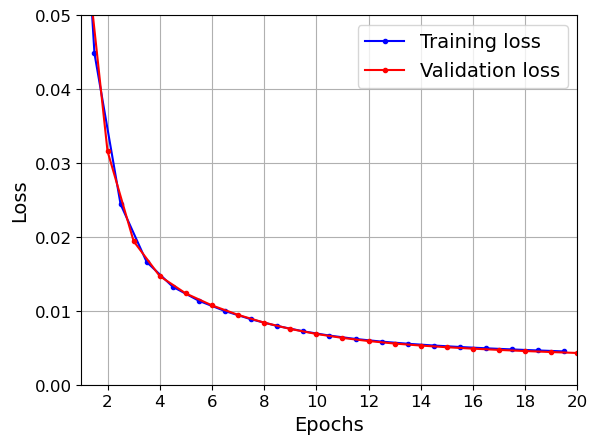

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


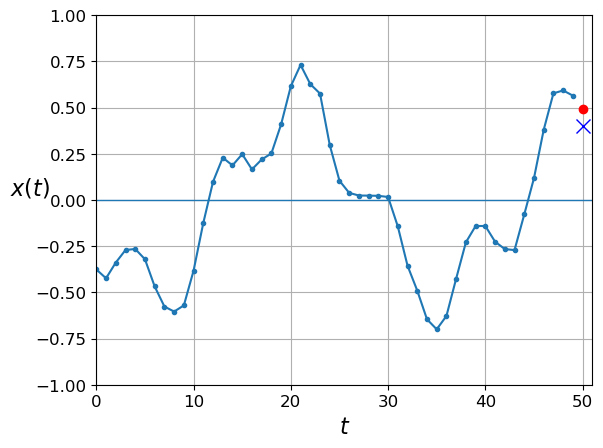

In [13]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8872 - val_loss: 0.3512
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2817 - val_loss: 0.1484
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1490 - val_loss: 0.1488
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1465 - val_loss: 0.1487
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1469 - val_loss: 0.1493
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1466 - val_loss: 0.1503
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1457 - val_loss: 0.1471
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1163 - val_loss: 0.0569
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0488 - val_loss: 0.0366
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0337 - val_loss: 0.0282
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0268 - val_loss: 0.0234
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [15]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116


0.011485731229186058

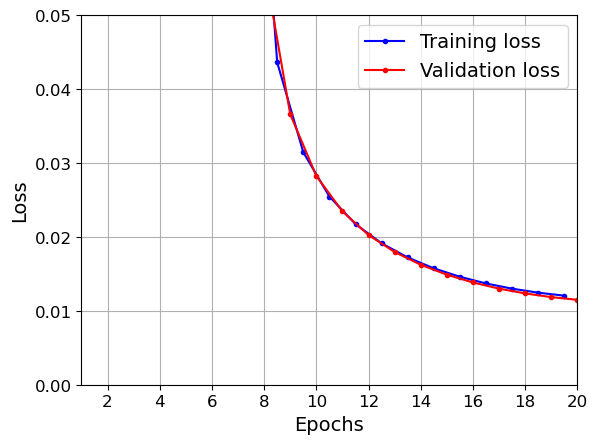

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


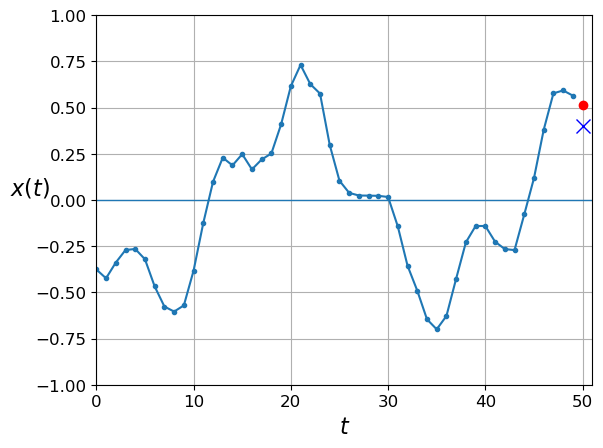

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0891 - val_loss: 0.0070
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029


0.003059328068047762

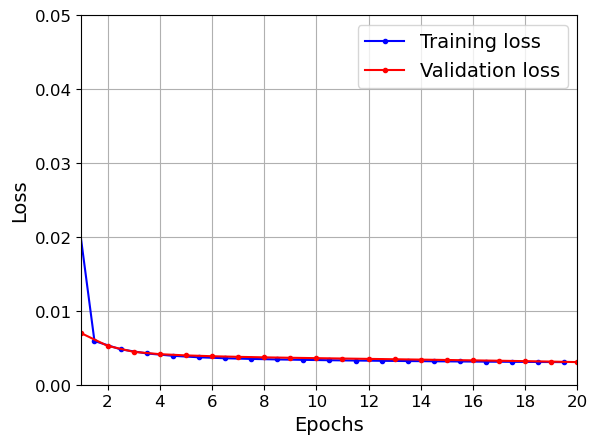

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


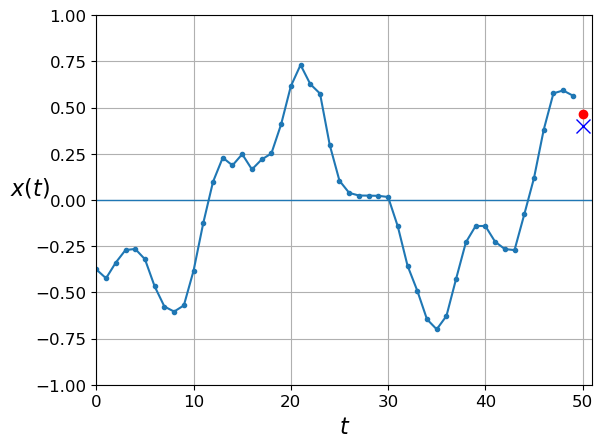

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1668 - val_loss: 0.0055
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [23]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031


0.0032604762818664312

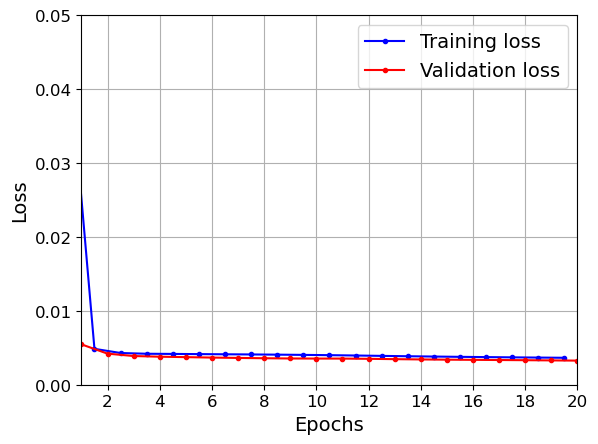

In [24]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


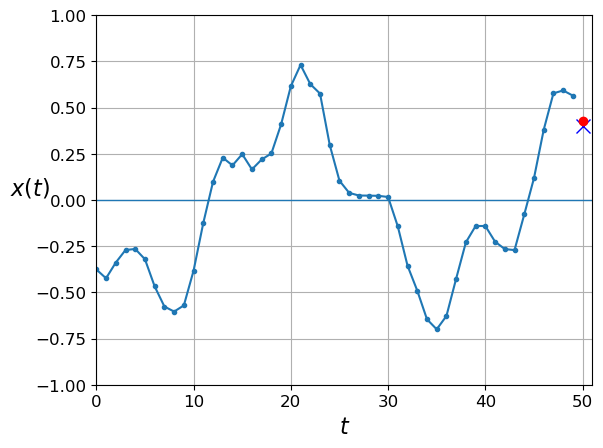

In [25]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [26]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [27]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


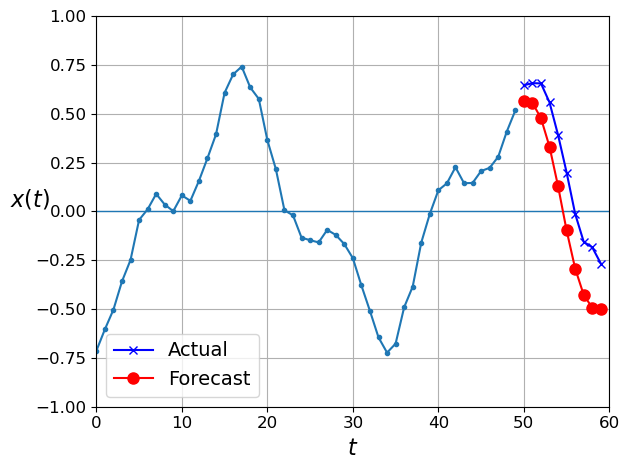

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bx-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "ro-", label="Forecast", markersize=8)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [30]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [31]:
Y_pred.shape

(2000, 10)

In [33]:
np.mean(mse(Y_valid, Y_pred))

0.040847104

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [37]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(mse(Y_valid, Y_naive_pred))

0.2227885

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2040 - val_loss: 0.0630
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0553 - val_loss: 0.0422
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 0.0400 - val_loss: 0.0349
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0340 - val_loss: 0.0312
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0306 - val_loss: 0.0288
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.0283 - val_loss: 0.0270
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0267 - val_loss: 0.0257
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0243 - val_loss: 0.0238
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 0.0235 - val_loss: 0.0231
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - loss: 0.0228 - val_loss: 0.0225
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━

Now let's create an RNN that predicts all 10 next values at once:

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1110 - val_loss: 0.0274
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0168 - val_loss: 0.0161
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0106 - val_loss: 0.0115
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0104 - val_loss: 0.0110
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0102 - val_loss: 0.0106
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s

In [40]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


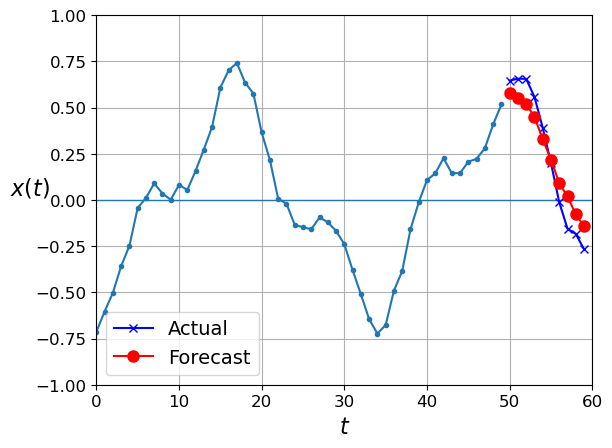

In [41]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [42]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [43]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return mse(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - last_time_step_mse: 0.0564 - loss: 0.0648 - val_last_time_step_mse: 0.0240 - val_loss: 0.0361
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0231 - loss: 0.0360 - val_last_time_step_mse: 0.0160 - val_loss: 0.0305
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0181 - loss: 0.0313 - val_last_time_step_mse: 0.0155 - val_loss: 0.0278
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0153 - loss: 0.0281 - val_last_time_step_mse: 0.0158 - val_loss: 0.0284
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - last_time_step_mse: 0.0130 - loss: 0.0262 - val_last_time_step_mse: 0.0129 - val_loss: 0.0252
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0113 - loss: 0.0242 - val_last_time_step_mse: 0.0092 - val_loss: 0.0219
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - last_time_step_mse: 0.0097 - loss: 0.0225 - val_las

In [47]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


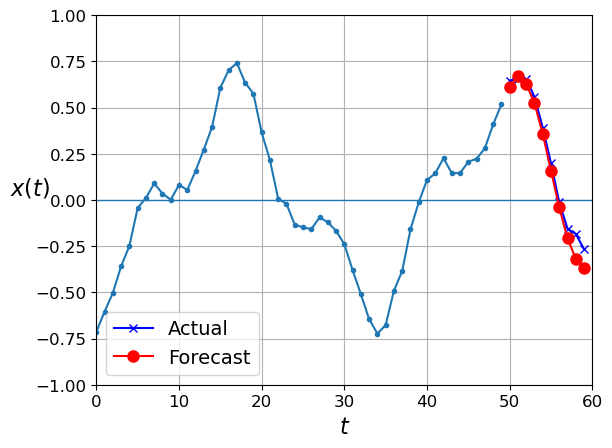

In [48]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - last_time_step_mse: 0.4993 - loss: 0.4957 - val_last_time_step_mse: 0.0697 - val_loss: 0.0749
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - last_time_step_mse: 0.0533 - loss: 0.0609 - val_last_time_step_mse: 0.0452 - val_loss: 0.0541
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0384 - loss: 0.0485 - val_last_time_step_mse: 0.0376 - val_loss: 0.0479
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0325 - loss: 0.0437 - val_last_time_step_mse: 0.0305 - val_loss: 0.0426
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0279 - loss: 0.0403 - val_last_time_step_mse: 0.0259 - val_loss: 0.0389
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - last_time_step_mse: 0.0249 - loss: 0.0381 - val_last_time_step_mse: 0.0234 - val_loss: 0.0370
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - last_time_step_mse: 0.0230 - loss: 0.0364 - val_las

# Deep RNNs with Layer Norm

In [50]:
from tensorflow.keras.layers import LayerNormalization

In [51]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


TypeError: Exception encountered when calling RNN.call().

[1mCannot convert the argument `type_value`: None to a TensorFlow DType.[0m

Arguments received by RNN.call():
  • sequences=tf.Tensor(shape=(None, 50, 1), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

# Creating a Custom RNN Class

In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 31s 134ms/step - loss: 0.3701 - last_time_step_mse: 0.3717 - val_loss: 0.0800 - val_last_time_step_mse: 0.0762
Epoch 2/20
219/219 [==============================] - 30s 135ms/step - loss: 0.0753 - last_time_step_mse: 0.0687 - val_loss: 0.0653 - val_last_time_step_mse: 0.0596
Epoch 3/20
219/219 [==============================] - 29s 135ms/step - loss: 0.0644 - last_time_step_mse: 0.0585 - val_loss: 0.0593 - val_last_time_step_mse: 0.0531
Epoch 4/20
219/219 [==============================] - 29s 133ms/step - loss: 0.0585 - last_time_step_mse: 0.0512 - val_loss: 0.0547 - val_last_time_step_mse: 0.0483
Epoch 5/20
219/219 [==============================] - 29s 133ms/step - loss: 0.0541 - last_time_step_mse: 0.0471 - val_loss: 0.0512 - val_last_time_step_mse: 0.0443
Epoch 6/20
219/219 [==============================] - 29s 132ms/step - loss: 0.0508 - last_time_step_mse: 0.0437 - val_loss: 0.0481 - val_last_time_step_mse: 0.0416
Epoch 7/20

# LSTMs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 12ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=======

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788688704371452, 0.00856081023812294]

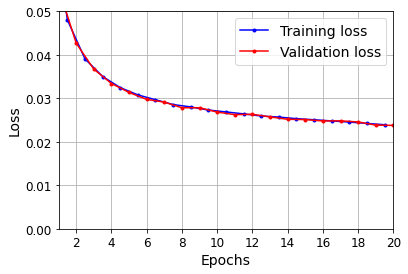

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

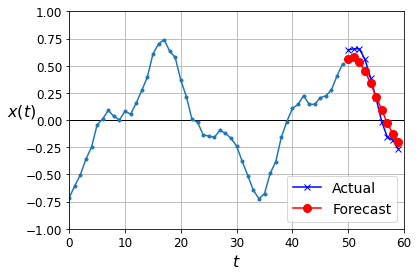

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 10ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.010262803174555302]

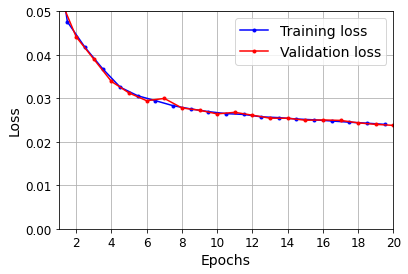

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

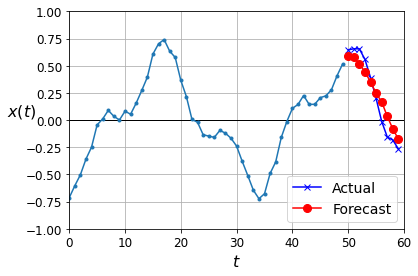

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 5s 9ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0981 - last_time_step_mse: 0.0890 - val_loss: 0.0365 - val_last_time_step_mse: 0.0230
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0339 - last_time_step_mse: 0.0211 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0144
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0245 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0234 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [ ]:
from tensorflow import keras

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 7ms/step - loss: 0.1387 - last_time_step_mse: 0.1347 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.1222 - last_time_step_mse: 0.1161 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.